In [1]:
%pylab inline
from astropy.io import fits
import glob
import pandas as pd
from pandas import DataFrame
from scipy.interpolate import interp1d
from nirspec import gluespec #,divspec
import pdb as pdb
import astropy
from astropy import units as u
from astroquery.hitran import Hitran
from flux_calculator import extract_hitran_data, calc_fluxes, extract_vup, make_rotation_diagram
import numpy as np
import pdb as pdb
from astropy.io import fits
from astropy.table import Table
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
def divspec(datadir, srcfile, stdfile, dtau=0, dpix=0, mode=None,plot=True):
    #Read in data for source and standard
    hdulist_src=fits.open(datadir+srcfile)
    data_src=hdulist_src[1].data
    hdr_src=hdulist_src[0].header
    hdulist_std=fits.open(datadir+stdfile)
    data_std=hdulist_std[1].data
    
    #Calculate the median without non-CO Emission Lines
    
    #Correcting for pflux_src outliers
    list_length = 1024
    cutoff = 1.1
    corrected_data = np.zeros(list_length) 
    for m in range(list_length):
        data = np.array(data_src['flux_pos'])
        val = np.median(data)*cutoff #This value is completely arbritrary and is what I though was best for the 2012/12/23 data, I'd like to look at more data sets to see what a better value might be
        if data[m] < val:
            corrected_data[m] = data[m] + 1
        else :
            corrected_data[m] = None
    corrected_median_pflux_src = np.nanmedian(corrected_data)
    
    #correcting for nflux_src outliers
    corrected_data = np.zeros(list_length)
    for n in range(list_length):
        data = np.array(data_src['flux_neg'])
        val = np.median(data)*cutoff
        if data[n] < val:
            corrected_data[n] = data[n] + 1
        else :
            corrected_data[n] = None
            data = np.array(data_src['flux_neg'])
    corrected_median_nflux_src = np.nanmedian(corrected_data)        
    
    #Normalize spectra
    pflux_src=data_src['flux_pos']/corrected_median_pflux_src
    nflux_src=data_src['flux_neg']/corrected_median_nflux_src
    pflux_std=data_std['flux_pos']/np.median(data_std['flux_pos'])
    nflux_std=data_std['flux_neg']/np.median(data_std['flux_neg'])
    
    pwave_src=data_src['wave_pos']
    nwave_src=data_src['wave_neg']
    pwave_std=data_std['wave_pos']
    nwave_std=data_std['wave_neg']


    #If desired, do airmass correction of standard
    np.seterr(invalid='ignore')
    pflux_std=np.exp((1+dtau)*np.log(pflux_std))
    nflux_std=np.exp((1+dtau)*np.log(nflux_std))

    #If desired, do wavelength shift of standard
    dwave=(pwave_src[1]-pwave_src[0])*dpix    #Convert pixel shift to wavelength shift
    pwave_std=pwave_std+dwave
    nwave_std=nwave_std+dwave

    #Interpolate everything onto positive src wavelengths
    nf_src=interp1d(nwave_src,nflux_src,bounds_error=False)
    pf_std=interp1d(pwave_std,pflux_std,bounds_error=False)
    nf_std=interp1d(nwave_std,nflux_std,bounds_error=False)

    nflux_src=nf_src(pwave_src)
    pflux_std=pf_std(pwave_src)
    nflux_std=nf_std(pwave_src)

    #Divide source by standard
    pdiv=pflux_src/pflux_std
    ndiv=nflux_src/nflux_std

    #Combine positive and negative beams
    divflux=(pdiv+ndiv)/2.
    srcflux=(pflux_src+nflux_src)/2.
    stdflux=(pflux_std+nflux_std)/2.

    #Compute SNR's in desired regions
    if(mode is not None):
        if(mode=='M0'):
            xsnr1_left=4.66
            xsnr1_right=4.67
            xsnr2_left=4.685
            xsnr2_right=4.69
            xsnr3_left=4.70
            xsnr3_right=4.715
        if(mode=='M1'):
            xsnr1_left=4.73
            xsnr1_right=4.75
            xsnr2_left=4.75
            xsnr2_right=4.77
            xsnr3_left=4.77
            xsnr3_right=4.79
        if(mode=='M2'):
            xsnr1_left=4.965
            xsnr1_right=4.975
            xsnr2_left=4.985
            xsnr2_right=5.0
            xsnr3_left=5.01
            xsnr3_right=5.015
        if(mode=='M3'):
            xsnr1_left=5.04
            xsnr1_right=5.05
            xsnr2_left=5.065
            xsnr2_right=5.075
            xsnr3_left=5.09
            xsnr3_right=5.095
        w1=((pwave_src > xsnr1_left) & (pwave_src<xsnr1_right))
        w2=((pwave_src > xsnr2_left) & (pwave_src<xsnr2_right))
        w3=((pwave_src > xsnr3_left) & (pwave_src<xsnr3_right))
    else:
        w1=np.isfinite(srcflux)
        w2=w1
        w3=w1
                
    snr1=np.nanmean(divflux[w1])/np.nanstd(divflux[w1])
    snr2=np.nanmean(divflux[w2])/np.nanstd(divflux[w2])
    snr3=np.nanmean(divflux[w3])/np.nanstd(divflux[w3])
    print('SNR:', snr1,snr2,snr3)

    #Create columns
    c1  = fits.Column(name='wave', format='D', array=pwave_src)
    c2  = fits.Column(name='div', format='D', array=divflux)
    c3  = fits.Column(name='src', format='D', array=srcflux)
    c4  = fits.Column(name='std', format='D', array=stdflux)
    coldefs = fits.ColDefs([c1,c2,c3,c4])
    tbhdu = fits.BinTableHDU.from_columns(coldefs)
    primary_hdu = fits.PrimaryHDU(header=hdr_src)    
    hdul = fits.HDUList([primary_hdu, tbhdu])

   #Create output file name
    srcname=srcfile.split('_')[0]
    date=srcfile.split('_')[1]
    stdname=stdfile.split('_')[0]
    srcnum=srcfile.split('_')[2]
    if(mode is not None): 
        outfile=srcname+'_'+stdname+'_'+date+'_'+srcnum+'_'+mode+'_div.fits'
    else:
        outfile=srcname+'_'+stdname+'_'+date+'_'+srcnum+'_div.fits'

    #Write to fits file    
    hdul.writeto(outfile,overwrite=True) 
    print('Writing to: ', outfile)

    #Create astropy table
    spectrum_table = Table([pwave_src, divflux, srcflux, stdflux], names=('wave', 'div', 'src','std'),  dtype=('f8', 'f8','f8','f8'))
    spectrum_table['wave'].unit = 'micron'

    if(plot==True):
        fig=plt.figure(figsize=(14,6))
        ax1=fig.add_subplot(211)
        ax1.plot(spectrum_table['wave'],spectrum_table['src'],label='src')
        ax1.plot(spectrum_table['wave'],spectrum_table['std'],label='std')
        ax1.legend()

        ax2=fig.add_subplot(212)
        ax2.plot(spectrum_table['wave'],spectrum_table['div'],label='div')
        ax2.set_ylim(0.8,1.2)
        ax2.legend()

        if(mode is not None):
            ax1.axvline(xsnr1_left,linestyle='--',color='C2')
            ax1.axvline(xsnr1_right,linestyle='--',color='C2')
            ax1.axvline(xsnr2_left,linestyle='--',color='C2')
            ax1.axvline(xsnr2_right,linestyle='--',color='C2')
            ax1.axvline(xsnr3_left,linestyle='--',color='C2')
            ax1.axvline(xsnr3_right,linestyle='--',color='C2')
            ax2.axvline(xsnr1_left,linestyle='--',color='C2')
            ax2.axvline(xsnr1_right,linestyle='--',color='C2')
            ax2.axvline(xsnr2_left,linestyle='--',color='C2')
            ax2.axvline(xsnr2_right,linestyle='--',color='C2')
            ax2.axvline(xsnr3_left,linestyle='--',color='C2')
            ax2.axvline(xsnr3_right,linestyle='--',color='C2')
        plt.show()

    return spectrum_table

**20101213**

In [3]:
datadir='/Users/hanna/Desktop/URSI/data/data/'
filelist=glob.glob(datadir+'*20101213*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    #print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

In [4]:
#20101213 This one looks pretty good
srcfile='ABAUR_20101213_1156_spec1d1.fits'
stdfile='HR1620_20101213_0919_spec1d1.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=0.08, dpix=-0.2, mode='M1')

SNR: 10.70562497684579 31.368382512121876 24.664292178673616
Writing to:  ABAUR_HR1620_20101213_1224_M3_div.fits


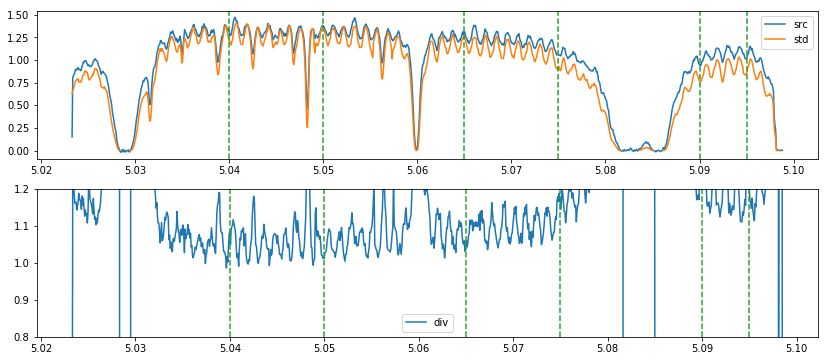

In [5]:
srcfile='ABAUR_20101213_1156_spec1d2.fits' #less than good
stdfile='HR1620_20101213_0919_spec1d2.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=0.6, dpix=-0.1, mode='M3')

srcfile='ABAUR_20101213_1224_spec1d1.fits' #good
stdfile='HR1620_20101213_0926_spec1d1.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=0.15, dpix=-0.3, mode='M1')

srcfile='ABAUR_20101213_1224_spec1d2.fits' #less than good
stdfile='HR1620_20101213_0926_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.8, dpix=-0.1, mode='M3')


**20101214**

In [6]:
datadir='/Users/hanna/Desktop/URSI/data/data/'
filelist=glob.glob(datadir+'*20101214*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    #print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

SNR: 57.449934419013125 59.04957785721107 69.9246369122228
Writing to:  ABAUR_HR383_20101214_1057_M3_div.fits


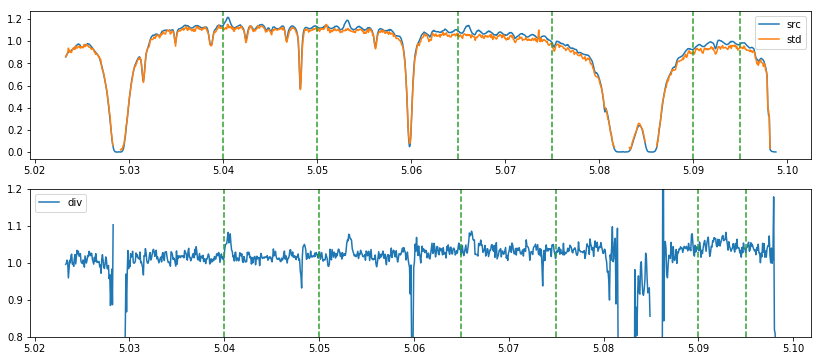

In [7]:
#20101214
srcfile='ABAUR_20101214_1032_spec1d1.fits' #3 peaks is kind of weid is it supposed to look like that?
stdfile='HR1620_20101214_0900_spec1d1.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=0.18, dpix=-0.0, mode='M1')

srcfile='ABAUR_20101214_1032_spec1d2.fits' #looks much better may want to revisit
stdfile='HR1620_20101214_0900_spec1d2.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=-0.1, dpix=0.5, mode='M3')

srcfile='ABAUR_20101214_1057_spec1d1.fits' #looks okay
stdfile='HR383_20101214_0459_spec1d1.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=0.07, dpix=-0.5, mode='M1')

srcfile='ABAUR_20101214_1057_spec1d2.fits'#big dips are weird but this might be as good of an emission signal as possible as this point
stdfile='HR383_20101214_0459_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.1, dpix=-0.1, mode='M3')



**20121231**

In [8]:
datadir='/Users/hanna/Desktop/URSI/data/data/'
filelist=glob.glob(datadir+'*20121231*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    #print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

SNR: 82.32334441580059 93.7857824268915 86.71553171711918
Writing to:  ABAUR_HR4494_20121231_1120_M3_div.fits


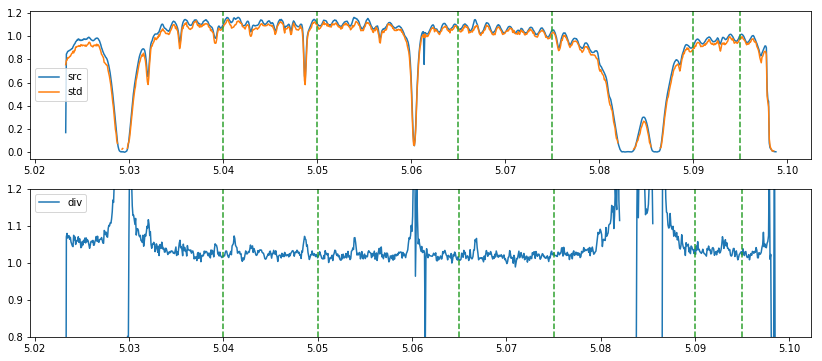

In [9]:
#20121231
srcfile='ABAUR_20121231_1051_spec1d1.fits' #starting to look much better
stdfile='HR2714_20121231_1330_spec1d1.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=-0.1, dpix=0.3, mode='M1')

srcfile='ABAUR_20121231_1051_spec1d2.fits' #looks better, less than great.
stdfile='HR2714_20121231_1330_spec1d2.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=-0.1, dpix=-0.1, mode='M3')

srcfile='ABAUR_20121231_1120_spec1d1.fits' #emission much clearer maybe revisit
stdfile='HR4494_20121231_1456_spec1d1.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=-0.15, dpix=-0.25, mode='M1')

srcfile='ABAUR_20121231_1120_spec1d2.fits' #definitly much better with dtau between -.2 and -.3. Might want to mess around with that range more
stdfile='HR4494_20121231_1456_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.1, dpix=-0.1, mode='M3')



**20130101**

In [10]:
datadir='/Users/hanna/Desktop/URSI/data/data/'
filelist=glob.glob(datadir+'*20130101*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

data\AATAU_20130101_0555_spec1d1.fits 1.18091 M-WIDE-AO 4.711393
data\AATAU_20130101_0555_spec1d2.fits 1.18091 M-WIDE-AO 5.023287
data\AATAU_20130101_0618_spec1d1.fits 1.11999 M-WIDE-AO 4.711393
data\AATAU_20130101_0618_spec1d2.fits 1.11999 M-WIDE-AO 5.023287
data\ABAUR_20130101_1056_spec1d1.fits 1.20446 M-WIDE-AO 4.646994
data\ABAUR_20130101_1056_spec1d2.fits 1.20446 M-WIDE-AO 4.954114
data\ABAUR_20130101_1122_spec1d1.fits 1.29239 M-WIDE-AO 4.646994
data\ABAUR_20130101_1122_spec1d2.fits 1.29239 M-WIDE-AO 4.954114
data\GMAUR_20130101_0705_spec1d1.fits 1.08204 M-WIDE-AO 4.711393
data\GMAUR_20130101_0705_spec1d2.fits 1.08204 M-WIDE-AO 5.023287
data\GMAUR_20130101_0758_spec1d1.fits 1.02657 M-WIDE-AO 4.711393
data\GMAUR_20130101_0758_spec1d2.fits 1.02657 M-WIDE-AO 5.023287
data\HR1177_20130101_0843_spec1d1.fits 1.07433 M-WIDE-AO 4.711393
data\HR1177_20130101_0843_spec1d2.fits 1.07433 M-WIDE-AO 5.023287
data\HR1620_20130101_0540_spec1d1.fits 1.34607 M-WIDE-AO 4.711393
data\HR1620_20130101_0

There is something weird about the 20130101 data onward.

[M2 = M0 , M4 = M2]

SNR: 37.160148813818296 16.853703390023085 23.41925576174418
Writing to:  ABAUR_HR2714_20130101_1122_M2_div.fits


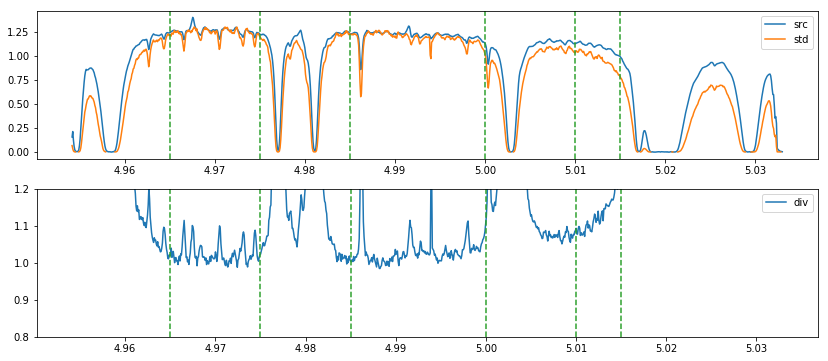

In [11]:
#20130101
srcfile='ABAUR_20130101_1056_spec1d1.fits' #there is a very large peak I cannot resolve. Might want to mess around with more
stdfile='HR1620_20130101_1028_spec1d1.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=-0.05, dpix=0.2, mode='M0')

srcfile='ABAUR_20130101_1056_spec1d2.fits' #was okay at +0.08, revisit
stdfile='HR1620_20130101_1028_spec1d2.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=0.15, dpix=0.2, mode='M2')

srcfile='ABAUR_20130101_1122_spec1d1.fits' #end very clean, choosing to ignore beginning.
stdfile='HR2714_20130101_1322_spec1d1.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=-0.15, dpix=0.1, mode='M0')

srcfile='ABAUR_20130101_1122_spec1d2.fits' #THIS ONE NEEDS TO BE FIXED 06/29
stdfile='HR2714_20130101_1322_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.99, dpix=-0.1, mode='M2')



**20130103**

In [12]:
datadir='/Users/hanna/Desktop/URSI/data/data/'
filelist=glob.glob(datadir+'*20130103*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

data\ABAUR_20130103_0837_spec1d1.fits 1.0187 M-WIDE-AO 4.646994
data\ABAUR_20130103_0837_spec1d2.fits 1.0187 M-WIDE-AO 4.954114
data\ABAUR_20130103_0913_spec1d1.fits 1.03557 M-WIDE-AO 4.646994
data\ABAUR_20130103_0913_spec1d2.fits 1.03557 M-WIDE-AO 4.954114
data\HD50138_20130103_1005_spec1d1.fits 1.12255 M-WIDE-AO 4.646994
data\HD50138_20130103_1005_spec1d2.fits 1.12255 M-WIDE-AO 4.954114
data\HD50138_20130103_1238_spec1d1.fits 1.3686 M-WIDE-AO 4.646994
data\HD50138_20130103_1238_spec1d2.fits 1.3686 M-WIDE-AO 4.954114
data\HR1620_20130103_0644_spec1d1.fits 1.1078 M-WIDE-AO 4.646994
data\HR1620_20130103_0644_spec1d2.fits 1.1078 M-WIDE-AO 4.954114
data\HR1620_20130103_0718_spec1d1.fits 1.04866 M-WIDE-AO 4.646994
data\HR1620_20130103_0718_spec1d2.fits 1.04866 M-WIDE-AO 4.954114
data\HR1620_20130103_0823_spec1d1.fits 1.00125 M-WIDE-AO 4.646994
data\HR1620_20130103_0823_spec1d2.fits 1.00125 M-WIDE-AO 4.954114
data\HR1620_20130103_1314_spec1d1.fits 1.35828 M-WIDE-AO 4.646994
data\HR1620_2013

SNR: 12.705362063748034 9.521792682156468 9.96164655723735
Writing to:  ABAUR_HR1620_20130103_0913_M2_div.fits


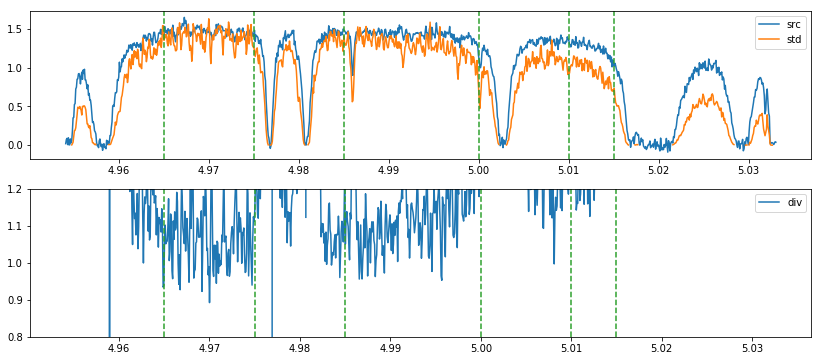

In [13]:
#20130103
srcfile='ABAUR_20130103_0837_spec1d1.fits' #Ask prof. Salyk for advice on this set. This is as good as it is going to be for now.
stdfile='HR1620_20130103_0823_spec1d1.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=-0.5, dpix=0.3, mode='M0')

srcfile='ABAUR_20130103_0837_spec1d2.fits'
stdfile='HR1620_20130103_0823_spec1d2.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=0.63, dpix=0.5, mode='M2') #come back to this one !!!

srcfile='ABAUR_20130103_0913_spec1d1.fits'
stdfile='HR1620_20130103_0718_spec1d1.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=-0.25, dpix=-0.1, mode='M0')

srcfile='ABAUR_20130103_0913_spec1d2.fits' #THIS ONE ALSO NEEDS TO BE FIXED 06/29
stdfile='HR1620_20130103_0718_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=1.3, dpix=-0.4, mode='M2')



**20131223**

In [14]:
datadir='/Users/hanna/Desktop/URSI/data/data/'
filelist=glob.glob(datadir+'*20131223*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

data\AATAU_20131223_0734_spec1d1.fits 1.05152 M-WIDE-AO 4.646994
data\AATAU_20131223_0734_spec1d2.fits 1.05152 M-WIDE-AO 4.954114
data\AATAU_20131223_0758_spec1d1.fits 1.02458 M-WIDE-AO 4.646994
data\AATAU_20131223_0758_spec1d2.fits 1.02458 M-WIDE-AO 4.954114
data\ABAUR_20131223_1118_spec1d1.fits 1.16299 M-WIDE-AO 4.646994
data\ABAUR_20131223_1118_spec1d2.fits 1.16299 M-WIDE-AO 4.954114
data\ABAUR_20131223_1136_spec1d1.fits 1.21435 M-WIDE-AO 4.646994
data\ABAUR_20131223_1136_spec1d2.fits 1.21435 M-WIDE-AO 4.954114
data\DOTAU_20131223_0559_spec1d1.fits 1.31167 M-WIDE-AO 4.646994
data\DOTAU_20131223_0559_spec1d2.fits 1.31167 M-WIDE-AO 4.954114
data\DOTAU_20131223_0653_spec1d1.fits 1.13377 M-WIDE-AO 4.646994
data\DOTAU_20131223_0653_spec1d2.fits 1.13377 M-WIDE-AO 4.954114
data\DOTAU_20131223_0700_spec1d1.fits 1.11806 M-WIDE-AO 4.646994
data\DOTAU_20131223_0700_spec1d2.fits 1.11806 M-WIDE-AO 4.954114
data\FNTAU_20131223_0827_spec1d1.fits 1.01141 M-WIDE-AO 4.646994
data\FNTAU_20131223_0827_

SNR: 34.02916641141956 10.668682513378414 11.104192275587042
Writing to:  ABAUR_HR1177_20131223_1136_M2_div.fits


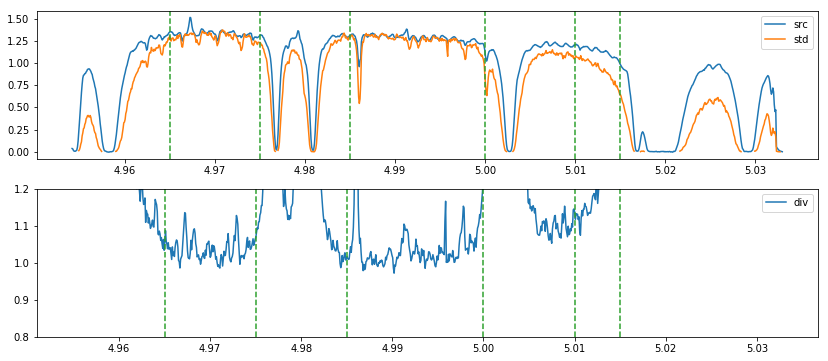

In [15]:
#20131223

srcfile='ABAUR_20131223_1118_spec1d1.fits' #ask for advice on this set too
stdfile='HR1177_20131223_0543_spec1d1.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=-0.5, dpix=-0.3, mode='M0')

srcfile='ABAUR_20131223_1136_spec1d1.fits' #can identify emission peaks but it's fuzzy
stdfile='HR1177_20131223_0543_spec1d1.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=-0.4, dpix=-0.7, mode='M0')


srcfile='ABAUR_20131223_1118_spec1d2.fits' #this one might be good
stdfile='HR1177_20131223_0543_spec1d2.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=0.0, dpix=-0.2, mode='M2')

srcfile='ABAUR_20131223_1136_spec1d2.fits' #good? compare to second set in this cell
stdfile='HR1177_20131223_0543_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.5, dpix=-0.4, mode='M2')



**20131224**

In [16]:
datadir='/Users/hanna/Desktop/URSI/data/data/'
filelist=glob.glob(datadir+'*20131224*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

data\ABAUR_20131224_1124_spec1d1.fits 1.19037 M-WIDE-AO 4.646994
data\ABAUR_20131224_1124_spec1d2.fits 1.19037 M-WIDE-AO 4.954114
data\ABAUR_20131224_1143_spec1d1.fits 1.25083 M-WIDE-AO 4.646994
data\ABAUR_20131224_1143_spec1d2.fits 1.25083 M-WIDE-AO 4.954114
data\DOTAU_20131224_0548_spec1d1.fits 1.3405 M-WIDE-AO 4.646994
data\DOTAU_20131224_0548_spec1d2.fits 1.3405 M-WIDE-AO 4.954114
data\DOTAU_20131224_0614_spec1d1.fits 1.23693 M-WIDE-AO 4.646994
data\DOTAU_20131224_0614_spec1d2.fits 1.23693 M-WIDE-AO 4.954114
data\FNTAU_20131224_0728_spec1d1.fits 1.03791 M-WIDE-AO 4.646994
data\FNTAU_20131224_0728_spec1d2.fits 1.03791 M-WIDE-AO 4.954114
data\FNTAU_20131224_0806_spec1d1.fits 1.01414 M-WIDE-AO 4.646994
data\FNTAU_20131224_0806_spec1d2.fits 1.01414 M-WIDE-AO 4.954114
data\GMAUR_20131224_0903_spec1d1.fits 1.01706 M-WIDE-AO 4.646994
data\GMAUR_20131224_0903_spec1d2.fits 1.01706 M-WIDE-AO 4.954114
data\GMAUR_20131224_0944_spec1d1.fits 1.02901 M-WIDE-AO 4.646994
data\GMAUR_20131224_0944_sp

SNR: 22.417190174947486 94.63867454667518 20.051596430090193
Writing to:  ABAUR_HR1177_20131224_1124_M0_div.fits


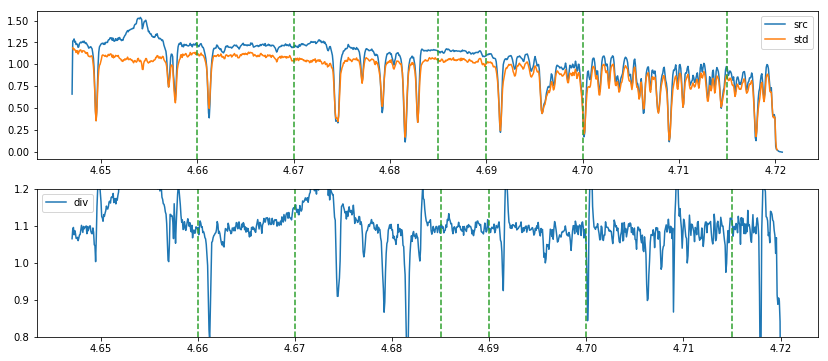

SNR: 24.700710738636598 71.43845958225448 16.936304431244157
Writing to:  ABAUR_HR1620_20131224_1143_M0_div.fits


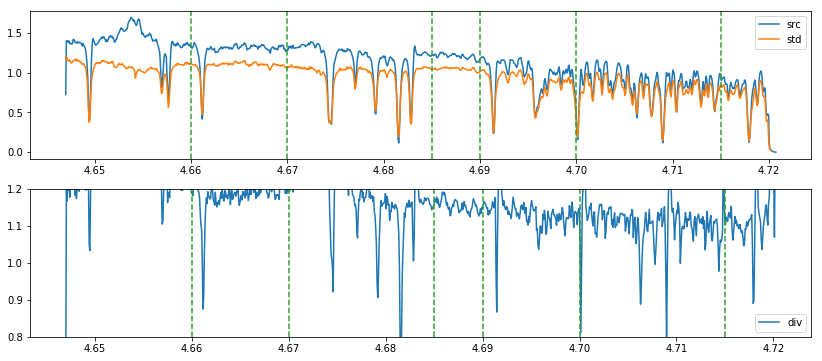

SNR: 49.5471729051905 48.070986002863776 57.640277837709554
Writing to:  ABAUR_HR1177_20131224_1124_M2_div.fits


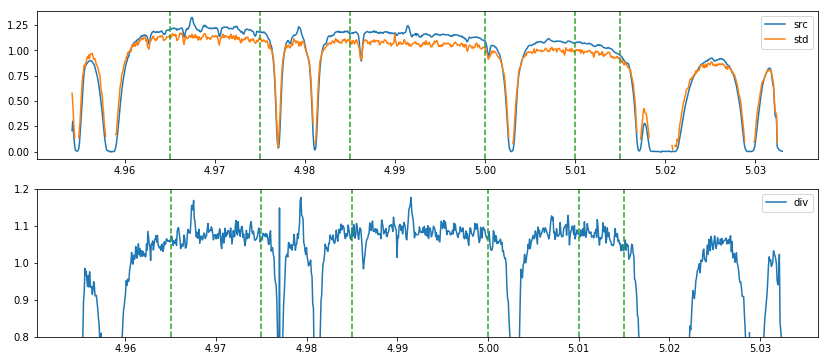

SNR: 36.92690930882949 48.60661046679033 73.56881922391422
Writing to:  ABAUR_HR1620_20131224_1143_M2_div.fits


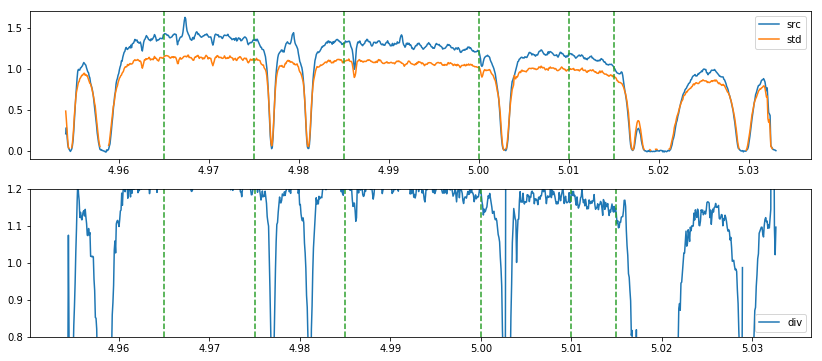

In [17]:
#20131224

srcfile='ABAUR_20131224_1124_spec1d1.fits'
stdfile='HR1177_20131224_0533_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.09, dpix=0.2, mode='M0')

srcfile='ABAUR_20131224_1143_spec1d1.fits'
stdfile='HR1620_20131224_0638_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.09, dpix=-0.9, mode='M0')

srcfile='ABAUR_20131224_1124_spec1d2.fits'
stdfile='HR1177_20131224_0533_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.15, dpix=-0.1, mode='M2')


srcfile='ABAUR_20131224_1143_spec1d2.fits'
stdfile='HR1620_20131224_0638_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=-0.05, dpix=-0.5, mode='M2')



**Combining Spectra Together**

In [18]:
ABAUR_2010121314_files = ['ABAUR_HR1620_20101213_1156_M1_div.fits', 'ABAUR_HR1620_20101213_1156_M3_div.fits','ABAUR_HR1620_20101213_1224_M1_div.fits', 'ABAUR_HR1620_20101213_1224_M3_div.fits','ABAUR_HR1620_20101214_1032_M1_div.fits', 'ABAUR_HR1620_20101214_1032_M3_div.fits', 'ABAUR_HR383_20101214_1057_M1_div.fits', 'ABAUR_HR383_20101214_1057_M3_div.fits']
ABAUR_20121231_files = ['ABAUR_HR1620_20130103_0913_M0_div.fits','ABAUR_HR1620_20130103_0837_M0_div.fits', 'ABAUR_HR2714_20130101_1122_M0_div.fits','ABAUR_HR1620_20130101_1056_M0_div.fits','ABAUR_HR2714_20121231_1051_M1_div.fits', 'ABAUR_HR2714_20121231_1051_M3_div.fits', 'ABAUR_HR4494_20121231_1120_M1_div.fits', 'ABAUR_HR4494_20121231_1120_M3_div.fits', 'ABAUR_HR1620_20130101_1056_M2_div.fits','ABAUR_HR2714_20130101_1122_M2_div.fits','ABAUR_HR1620_20130103_0837_M2_div.fits','ABAUR_HR1620_20130103_0913_M2_div.fits']
ABAUR_2013122324_files = ['ABAUR_HR1177_20131223_1118_M2_div.fits','ABAUR_HR1177_20131223_1136_M2_div.fits','ABAUR_HR1177_20131224_1124_M0_div.fits','ABAUR_HR1177_20131224_1124_M2_div.fits','ABAUR_HR1620_20131224_1143_M0_div.fits','ABAUR_HR1620_20131224_1143_M2_div.fits', 'ABAUR_HR1177_20131223_1136_M0_div.fits','ABAUR_HR1177_20131223_1118_M0_div.fits',]

In [19]:
(wave,div)=gluespec('/Users/hanna/Desktop/URSI/',ABAUR_2010121314_files)
(wave,div)=gluespec('/Users/hanna/Desktop/URSI/',ABAUR_20121231_files)
(wave,div)=gluespec('/Users/hanna/Desktop/URSI/',ABAUR_2013122324_files)

Writing to:  ABAUR_20101213_glue.fits
Writing to:  ABAUR_20130103_glue.fits
Writing to:  ABAUR_20131223_glue.fits


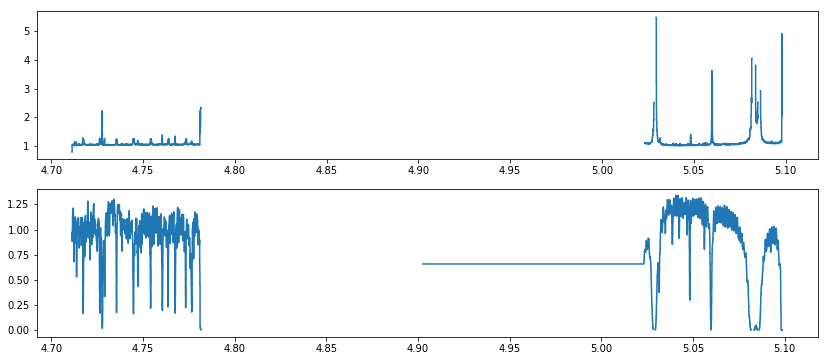

In [20]:
hdulist=fits.open('/Users/hanna/Desktop/URSI/ABAUR_20101213_glue.fits')
data=hdulist[1].data
fig=plt.figure(figsize=(14,6))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

ax1.plot(data['wave'],data['div'],linestyle='steps-mid')
ax2.plot(data['wave'],data['std'],linestyle='steps-mid')

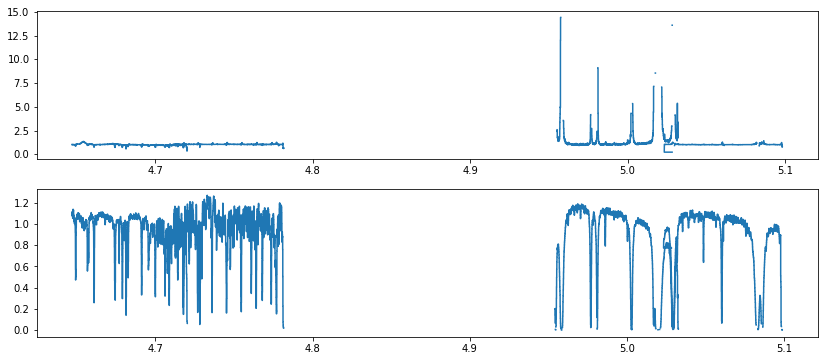

In [21]:
hdulist=fits.open('/Users/hanna/Desktop/URSI/ABAUR_20130103_glue.fits')
data=hdulist[1].data
fig=plt.figure(figsize=(14,6))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

ax1.plot(data['wave'],data['div'],linestyle='steps-mid')
ax2.plot(data['wave'],data['std'],linestyle='steps-mid')

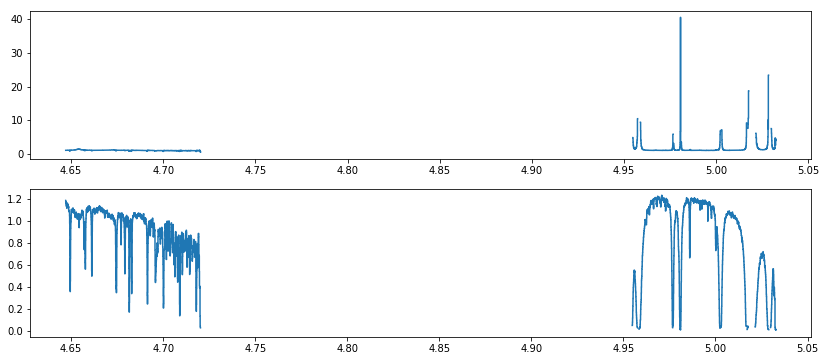

In [22]:
hdulist=fits.open('/Users/hanna/Desktop/URSI/ABAUR_20131223_glue.fits')
data=hdulist[1].data
fig=plt.figure(figsize=(14,6))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

ax1.plot(data['wave'],data['div'],linestyle='steps-mid')
ax2.plot(data['wave'],data['std'],linestyle='steps-mid')